In [11]:
import STAGATE
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import os
import sys
from sklearn import metrics
from pathlib import Path

In [12]:
data_root = Path('../data/DLPFC')

# sample name
sample_name = '151674'
n_clusters = 5 if sample_name in ['151669', '151670', '151671', '151672'] else 7
adata = sc.read_visium(data_root / sample_name)
print(adata)
adata.var_names_make_unique()

/data/hgh/anaconda3/envs/STAGATE/lib/python3.7/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 3673 × 33538
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'


In [13]:
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [14]:
df_meta = pd.read_csv(data_root / sample_name / 'metadata.tsv', sep='\t')
adata.obs['Ground Truth'] = df_meta['layer_guess']

------Calculating spatial graph...
The graph contains 21258 edges, 3673 cells.
5.7876 neighbors per cell on average.


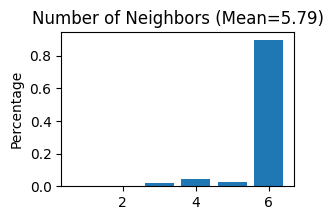

In [15]:
STAGATE.Cal_Spatial_Net(adata, rad_cutoff=150)
STAGATE.Stats_Spatial_Net(adata)

In [16]:
adata = STAGATE.train_STAGATE(adata, alpha=0)

Size of Input:  (3673, 3000)


2025-01-13 15:35:33.618974: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: Tesla V100-PCIE-32GB major: 7 minor: 0 memoryClockRate(GHz): 1.38
pciBusID: 0000:9b:00.0
2025-01-13 15:35:33.619892: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 1 with properties: 
name: Tesla V100-PCIE-32GB major: 7 minor: 0 memoryClockRate(GHz): 1.38
pciBusID: 0000:c8:00.0
2025-01-13 15:35:33.619957: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2025-01-13 15:35:33.619974: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2025-01-13 15:35:33.619988: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10.0
2025-01-13 15:35:33.620001: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand

In [17]:
adata = STAGATE.mclust_R(adata, used_obsm='STAGATE', num_cluster=n_clusters)

fitting ...
  |======================================================================| 100%


In [18]:
obs_df = adata.obs.dropna()
ARI = metrics.adjusted_rand_score(obs_df['mclust'], obs_df['Ground Truth'])
NMI = metrics.normalized_mutual_info_score(obs_df['mclust'], obs_df['Ground Truth'])
print('Adjusted rand index = %.4f' %ARI)

Adjusted rand index = 0.3731


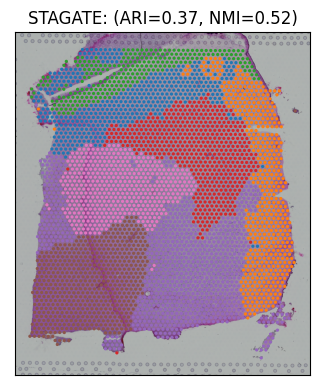

<Figure size 640x480 with 0 Axes>

In [21]:
fig, axs = plt.subplots(1, 1, figsize=(4, 4))

# 绘制空间数据并指定轴对象
sc.pl.spatial(
    adata,
    color="mclust",
    title=('STAGATE: (ARI=%.2f, NMI=%.2f)' % (ARI, NMI)),
    ax=axs,
    show=False,
    legend_loc=None
)
axs.set_xlabel('')
axs.set_ylabel('')
plt.tight_layout() 
output_dir = ('./STAGATE_ARI_NMI')
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
output_path = os.path.join(output_dir, f"STAGATE_{sample_name}_ARI.svg")
plt.savefig(output_path, dpi=300, bbox_inches='tight')
plt.show()
plt.clf()
plt.close(fig)

In [10]:
# 保存 adata 为 h5ad 文件
output_dir1 = ('./feature')
if not os.path.exists(output_dir1):
    os.makedirs(output_dir1)
output_path = os.path.join(output_dir1, f"{sample_name}.h5ad")
adata.write_h5ad(output_path)